In [1]:
# General Imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import geopandas
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torch.autograd import Variable

import warnings
import random
import time
from tifffile import imsave

import skimage
from skimage.transform import rescale
import cv2

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import wandb

In [2]:
# local imports
from dataloader_save_factor4 import Dataset

In [3]:
# define paths
spot6_mosaic = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'
spot6_path = "/home/simon/CDE_UBS/thesis/data_collection/spot6/"
sen2_path = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"
closest_dates_filepath = "/home/simon/CDE_UBS/thesis/data_loader/data/closest_dates.pkl"

# get dataset object
dataset = Dataset(spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,window_size=500,factor=(10/1.5))
loader = DataLoader(dataset,batch_size=1, shuffle=True, num_workers=1)
print("Loader Length: ",len(loader))

precalculated dataset file found, loading...

Dataset Object successfully instanciated!
Loader Length:  53590


## Save images to files

In [4]:
    def extract_window(filepath,coordinates,window_size=500,show=False):
        """
        Inputs:
            - filepath of mosaic raster
            - point coordinates of window
            - window size in pixels
        Outputs:
            - window array from input mosaic at desired location
        
        """
        import rasterio
        import numpy as np

        # if coordinates == singular tuple of coordinates, wrap it in list
        if type(coordinates)!=list:
            coordinates = [coordinates]

        with rasterio.open(filepath) as dataset:
            # Loop through your list of coords
            for i, (lon, lat) in enumerate(coordinates):

                # Get pixel coordinates from map coordinates
                py, px = dataset.index(lon, lat)
                #print('Pixel Y, X coords: {}, {}'.format(py, px))

                # Build an NxN window (centered)
                window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
                #print(window)

                # Read the data in the window
                # clip is a nbands * N * N numpy array
                clip = dataset.read(window=window)

                if show:
                    if clip.shape == (3, window_size, window_size):
                        image_standard_form = np.transpose(clip, (2, 1, 0))
                        plt.imshow(image_standard_form)
                        plt.show()
                    else:
                        print("Shape invalid - most likely edge window")

        return(clip)

    def interpolate(img,size=500):
        """
        Input:
            - Image
        Output:
            - Image upsampled to 500*500
        """
        dim = (size, size)
        b1 = cv2.resize(img[0], dim, interpolation = cv2.INTER_CUBIC)
        b2 = cv2.resize(img[1], dim, interpolation = cv2.INTER_CUBIC)
        b3 = cv2.resize(img[2], dim, interpolation = cv2.INTER_CUBIC)
        
        img = np.dstack((b1,b2,b3))
        img = np.transpose(img,(2,0,1))
 
        return(img)

In [5]:
def extract_sen2_valid(dic):
    # find valid data
    valid_acq = []
    for i in dic:
        if dic[i][2] == True:
            valid_acq.append(i)
    return(valid_acq)
    

In [7]:
df = pd.read_pickle("final_dataset.pkl")

In [9]:
mosaic_path = "/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif"
sen2_path   = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"

spot6_export_path = "data_f4_v2/y/"
sen2_export_path  = "data_f4_v2/x/"


count = 0
spot6_filenames = []
sen2_filenames = []
sen2_number = []
sen2_tiles = []


for row in df.iterrows():
    """Extract Spot6"""
    # extract spot6 image window
    spot6 = extract_window(mosaic_path,(row[1]["x"],row[1]["y"]))
    # set export filename
    spot6_name = str(row[1]["name"][:29])+"_"+str(row[1]["x"])+"_"+str(row[1]["y"])+".tif"
    # append to list
    spot6_filenames.append(spot6_name)
    # interpolate image
    spot6 = interpolate(spot6,300)
    # save image
    imsave(spot6_export_path+spot6_name, spot6)
    
    
    "Extract Sen2"
    # get dict valid inf
    dict_sen2 = row[1]["other_valid_acq"]
    print(dict_sen2)
    sen2_valid_dates = extract_sen2_valid(dict_sen2)
    print(sen2_valid_dates)
    
    
    # iterate and save
    counter_sen2_files = 0
    sen2_file_names_ = []
    for i in sen2_valid_dates:
        # create export name
        sen2_export_name = dict_sen2[i][1][:61]+"_"+str(row[1]["x"])+"_"+str(row[1]["y"])+"_"+str(i)+str("days.tif")
        # get filepath+name of original image
        sen2_filename = sen2_path+dict_sen2[i][1]
        # get window
        sen2 = extract_window(sen2_filename,(row[1]["x"],row[1]["y"]),window_size=75)
        # increase counter to see how many sen2 images there are
        counter_sen2_files = counter_sen2_files+1
        # append filename to list to save
        sen2_file_names_.append(sen2_export_name)
        # SAVE
        imsave(sen2_export_path+sen2_export_name, sen2)

    sen2_tiles.append(sen2_export_name[35:41])
    
    
    sen2_filenames.append(sen2_file_names_)
    sen2_number.append(counter_sen2_files)
    
    count=count+1
    if count%100==0:
        print(count,"/",len(df),end="\r")
        
        
        
# append info to original dataframe
df["sen2_no"] = sen2_number
df["sen2_filenames"] = sen2_filenames
df["sen2_tile"] = sen2_tiles
df["spot6_filenames"] = spot6_filenames

df.to_pickle("df_saved_images_v2.pkl")

{33: [Timestamp('2018-04-03 00:00:00'), 'SENTINEL2A_20180403-113452-260_L2A_T30UUU_C_V2-2_FRE_RGB_2154.tif', False], 37: [Timestamp('2018-06-12 00:00:00'), 'SENTINEL2A_20180612-113318-463_L2A_T30UUU_C_V2-2_FRE_RGB_2154.tif', False], 17: [Timestamp('2018-05-23 00:00:00'), 'SENTINEL2A_20180523-113321-464_L2A_T30UUU_C_V2-2_FRE_RGB_2154.tif', False], 47: [Timestamp('2018-06-22 00:00:00'), 'SENTINEL2A_20180622-113442-435_L2A_T30UUU_C_V2-2_FRE_RGB_2154.tif', False], 14: [Timestamp('2018-05-20 00:00:00'), 'SENTINEL2A_20180520-112543-431_L2A_T30UUU_C_V2-2_FRE_RGB_2154.tif', False], 67: [Timestamp('2018-07-12 00:00:00'), 'SENTINEL2A_20180712-113320-460_L2A_T30UUU_D_V1-8_FRE_RGB_2154.tif', False], 87: [Timestamp('2018-08-01 00:00:00'), 'SENTINEL2A_20180801-113319-457_L2A_T30UUU_C_V2-2_FRE_RGB_2154.tif', False], 119: [Timestamp('2018-09-02 00:00:00'), 'SENTINEL2B_20180902-112716-061_L2A_T30UUU_C_V2-2_FRE_RGB_2154.tif', False], 1: [Timestamp('2018-05-05 00:00:00'), 'SENTINEL2B_20180505-112304-300_

NameError: name 'sen2_export_name' is not defined

In [ ]:
df.to_csv("export_v2.csv")

In [30]:
df

,index,x,y,geometry,index_right,name,min,max,other_acq,geom,other_valid_acq,spot6_validity,amount
0,0,99000.0,6843750.0,POINT (99000.000 6843750.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684...","{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...",True,5
1,1,99000.0,6844500.0,POINT (99000.000 6844500.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684...","{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...",True,5
2,2,99000.0,6845250.0,POINT (99000.000 6845250.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684...","{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...",True,5
3,3,99000.0,6846000.0,POINT (99000.000 6846000.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684...","{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...",True,5
4,3,99000.0,6846000.0,POINT (99000.000 6846000.000),1969,ORT_2018_0099_6849_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6849000.000, 99000.000 684...","{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...",False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82594,53585,401250.0,6828000.0,POINT (401250.000 6828000.000),3334,ORT_2018_0399_6831_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6831000.000, 399000.000 6...","{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...",False,10
82595,53586,401250.0,6828750.0,POINT (401250.000 6828750.000),3334,ORT_2018_0399_6831_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6831000.000, 399000.000 6...","{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...",True,10
82596,53587,401250.0,6829500.0,POINT (401250.000 6829500.000),3334,ORT_2018_0399_6831_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6831000.000, 399000.000 6...","{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...",True,10
82597,53588,401250.0,6830250.0,POINT (401250.000 6830250.000),3334,ORT_2018_0399_6831_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6831000.000, 399000.000 6...","{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...",True,10


In [25]:
df = pd.read_pickle("final_dataset.pkl")

In [26]:
l = []
for i in df["other_valid_acq"]:
    s = 0
    for j in i:
        #print(i[j][-1])
        if i[j][-1] == True:
            s=s+1
    l.append(s)
df["amount"] = l

<AxesSubplot:ylabel='Frequency'>

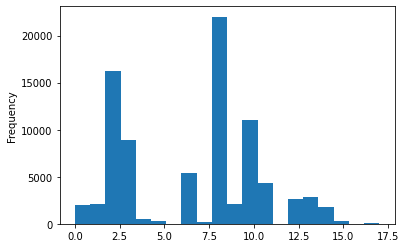

In [29]:
df["amount"].plot.hist(bins=20)

In [28]:
df.to_csv("export.csv")